In [54]:
%cd 'scripts'
from dataLoader import *
from helper import *
dl = dataLoader(pt_perc = {'metabs': .25, '16s': .05, 'scfa': 0, 'toxin':0}, meas_thresh = 
                {'metabs': 0, '16s': 10, 'scfa': 0, 'toxin':0}, 
                var_perc = {'metabs': 15, '16s': 5, 'scfa': 0, 'toxin':0})


[Errno 2] No such file or directory: 'scripts'
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts


/Users/jendawk/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


metabs
(240, 1256)
(240, 1161)
16s
(231, 384)
(231, 384)
scfa
(240, 9)
(240, 8)
toxin
(240, 3)
(240, 3)


In [3]:
import scipy.stats as st
from collections import Counter
import sklearn
from matplotlib import cm
import scipy
import  itertools
from datetime import datetime

from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl
import re
from matplotlib_venn import venn3, venn2
from statsmodels.stats.multitest import multipletests

In [11]:
cs_groups = pd.read_csv('inputs/20200120_HumanCarbonSourceMap.csv', index_col = 0)
cs_dict = {}
for group in cs_groups.index.values:
    cs_dict[group] = '; '.join(cs_groups.loc[group][1:].dropna())
cs_dict_rev = {}
for metabolite in dl.col_mat_mets.index.values:
    loc = np.where(cs_groups==metabolite)[0]
    if len(loc)>0:
        cs_dict_rev[metabolite] = '; '.join(cs_groups.index.values[loc])
    else:
        cs_dict_rev[metabolite] = 'None'
cs_map = pd.Series(cs_dict_rev)

In [15]:
import math
def combination(n,k):
    return math.factorial(n)/(math.factorial(k)*math.factorial(n-k))

In [130]:
def ora(x, X):
    N = len(X)
    n = len(x)
    print('n=' + str(n))
    num_hits = {}
    num_hits_expected = {}
    prob = {}
    for group in np.unique(x):
        k = np.sum(np.array(x)==group)
        K = np.sum(np.array(X)==group)
        if K < 4 or k < 3 or group == 'None' or group == 'Partially Characterized Molecules':
            print(group + ': K='+str(K) + ', k=' + str(k))
            continue
        num_hits[group] = k
        num_hits_expected[group] = (K/N)*n
        prob[group] = (combination(K,k)*combination(N-K, n-k))/combination(N,n)
    if len(prob)==0:
        return None

    gps, pvals = zip(*prob.items())
    reject, corrected, a1, a2 = multipletests(list(pvals), alpha=.05, method='fdr_bh')
    fdr = {gp:corr for gp, corr in zip(gps, corrected)}
    out_df = pd.DataFrame({'# Hits':num_hits, '# Expected Hits': num_hits_expected, 'p-value': prob, 'FDR': fdr})
    return out_df.sort_values('p-value', ascending = True)

In [136]:
path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/univariate_analysis/metabs/ttest_metabs0_1_Non-recurrer.csv'
df = pd.read_csv(path, index_col = 0)
CG = cs_map.loc[df.index.values]
SUP = dl.col_mat_mets['SUPER_PATHWAY'].loc[df.index.values]
SUB = dl.col_mat_mets['SUB_PATHWAY'].loc[df.index.values]
mets = df.index.values[df['BH corrected']<= 0.05]
cg = cs_map.loc[mets]
sup = dl.col_mat_mets['SUPER_PATHWAY'].loc[mets]
sub = dl.col_mat_mets['SUB_PATHWAY'].loc[mets]

In [137]:
ora(cg, CG)

n=228
Acyl-carnitine, Long Chain: K=3, k=1
AminoSuGARS: K=3, k=1
Carotenoids/Vitamin A: K=4, k=1
Ceramides: K=5, k=2
Fatty Acids-Long Chain Monounsaturated: K=1, k=1
Fatty Acids-Long Chain Polyunsaturated: K=6, k=1
Hemoglobin and Porphyrin Metabolism: K=9, k=1
N-acetyl Amino Acids: K=2, k=1
Nicotinamides: K=4, k=1
Non-volatile SCFA: K=2, k=1
None: K=352, k=101
Other Vitamins and Cofactors: K=8, k=1
Phosphatidylcholines: K=6, k=1
Plasmalogens: K=2, k=2
Polyamines: K=5, k=1
Polyamines; N-acetyl Amino Acids: K=1, k=1
Primary Bile Acids: K=10, k=1
Progestin Steroids: K=5, k=1
Purines-Adenine Containing: K=5, k=2
Purines-Guanine-Containing: K=5, k=2
Purines-Xanthines/Inosine: K=2, k=1
SCFA: K=4, k=1
Tocopherols: K=7, k=2


,# Hits,# Expected Hits,p-value,FDR
Sphingomyelins,14,4.2,3.590430e-08,6.462774e-07
Diacylglycerols,16,6.6,2.913275e-05,2.621947e-04
Pyrimidines-Cytidine/Orotate,7,3.0,8.655805e-03,5.193483e-02
Disaccharides and Oligosaccharides,4,1.8,5.902825e-02,2.256013e-01
Secondary Bile Acids,7,10.5,6.623753e-02,2.256013e-01
Fatty Acids-Branched,3,1.2,7.520043e-02,2.256013e-01
Acyl-glycine,5,3.0,1.025554e-01,2.307497e-01
Pyrimidines-Tymine/Uracil,5,3.0,1.025554e-01,2.307497e-01
Galactosyl Glycerolipids,3,5.1,1.238428e-01,2.448524e-01
Sterols,4,2.4,1.360291e-01,2.448524e-01


In [138]:
ora(sup, SUP)

n=228
Energy: K=3, k=2
Partially Characterized Molecules: K=21, k=7


,# Hits,# Expected Hits,p-value,FDR
Nucleotide,28,12.9,8.033942e-07,0.000006
Amino Acid,25,31.5,3.065450e-02,0.105318
Xenobiotics,60,65.4,4.513633e-02,0.105318
Lipid,89,88.8,6.462484e-02,0.113093
Cofactors and Vitamins,6,9.0,8.185609e-02,0.114599
Peptide,6,8.1,1.206588e-01,0.140769
Carbohydrate,5,5.1,2.104611e-01,0.210461


In [139]:
ora(sub, SUB)

n=228
Aminosugar Metabolism: K=3, k=1
Ceramides: K=2, k=2
Chemical: K=14, k=1
Dihydrosphingomyelins: K=1, k=1
Drug - Antibiotic: K=1, k=1
Drug - Other: K=1, k=1
Fatty Acid Metabolism (Acyl Carnitine, Long Chain Saturated): K=3, k=1
Fatty Acid Metabolism (Acyl Glutamine): K=3, k=1
Glutamate Metabolism: K=6, k=1
Glutathione Metabolism: K=2, k=2
Glycine, Serine and Threonine Metabolism: K=4, k=1
Hemoglobin and Porphyrin Metabolism: K=5, k=1
Histidine Metabolism: K=7, k=2
Inositol Metabolism: K=1, k=1
Lactosylceramides (LCER): K=2, k=1
Long Chain Monounsaturated Fatty Acid: K=1, k=1
Long Chain Polyunsaturated Fatty Acid (n3 and n6): K=6, k=1
Lysine Metabolism: K=6, k=1
Nicotinate and Nicotinamide Metabolism: K=4, k=1
Partially Characterized Molecules: K=21, k=7
Phenylalanine Metabolism: K=7, k=1
Phosphatidylcholine (PC): K=6, k=1
Phosphatidylserine (PS): K=1, k=1
Plasmalogen: K=2, k=2
Polyamine Metabolism: K=6, k=2
Primary Bile Acid Metabolism: K=10, k=1
Progestin Steroids: K=5, k=1
Pterin

,# Hits,# Expected Hits,p-value,FDR
Sphingomyelins,14,4.2,3.590430e-08,8.257989e-07
Dinucleotide,11,3.3,1.491072e-06,1.714732e-05
Diacylglycerol,16,6.6,2.913275e-05,2.233511e-04
"Pyrimidine Metabolism, Cytidine containing",5,2.1,2.455074e-02,1.411668e-01
Food Component/Plant,48,42.9,4.666507e-02,2.146593e-01
Disaccharides and Oligosaccharides,4,1.8,5.902825e-02,2.162012e-01
Secondary Bile Acid Metabolism,7,10.5,6.623753e-02,2.162012e-01
"Fatty Acid, Branched",3,1.2,7.520043e-02,2.162012e-01
Fatty Acid Metabolism (Acyl Glycine),5,3.0,1.025554e-01,2.406669e-01
Galactosyl Glycerolipids,3,5.1,1.238428e-01,2.406669e-01


In [39]:
path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/univariate_analysis/metabs/ttest_metabs1_2_Non-recurrer.csv'
df = pd.read_csv(path, index_col = 0)
CG = cs_map.loc[df.index.values]
SUP = dl.col_mat_mets['SUPER_PATHWAY'].loc[df.index.values]
SUB = dl.col_mat_mets['SUB_PATHWAY'].loc[df.index.values]
mets = df.index.values[df['BH corrected']<= 0.05]
cg = cs_map.loc[mets]
sup = dl.col_mat_mets['SUPER_PATHWAY'].loc[mets]
sub = dl.col_mat_mets['SUB_PATHWAY'].loc[mets]

In [93]:
# Don't test none category

In [94]:
ora(cg, CG)

Acyl-carnitine, Monounsaturated: K=5, k=2
AminoSuGARS: K=3, k=1
Aromatic Compounds: K=12, k=2
Ascorbate and Metabolites: K=2, k=1
Ceramides: K=5, k=1
Endocannabinoids: K=14, k=2
Fatty Acids-Long Chain Polyunsaturated: K=6, k=2
Gamma-glutamyl Amino Acids: K=12, k=2
Hexoses: K=1, k=1
Non-volatile SCFA: K=2, k=1
None: K=352, k=52
Polyamines: K=5, k=1
Progestin Steroids: K=5, k=2
Purines-Adenine Containing: K=5, k=1
Purines-Guanine-Containing: K=5, k=1
Pyrimidines-Cytidine/Orotate: K=10, k=2
Sphingosines: K=3, k=1
Steroids-other: K=3, k=1
Sterols: K=8, k=1
Stickland Acceptor Amino Acids: K=2, k=1
Sugar Alcohols and Acids: K=1, k=1
Tocopherols: K=7, k=1


,# Hits,# Expected Hits,p-value,FDR
Secondary Bile Acids,11,5.572368,0.009694,0.044477
Primary Bile Acids,5,1.592105,0.010408,0.044477
"Acyl-carnitine, Hydroxy",3,0.636842,0.013343,0.044477
Corticosteroids,3,0.796053,0.028151,0.066806
Hemoglobin and Porphyrin Metabolism,4,1.432895,0.033403,0.066806
Disaccharides and Oligosaccharides,3,0.955263,0.047502,0.079171
Other Vitamins and Cofactors,3,1.273684,0.094610,0.135157
Pyrimidines-Tymine/Uracil,3,1.592105,0.144068,0.180084
Androgenic Steroids,3,2.547368,0.239816,0.246994
Fatty Acids-Monohydroxy,3,3.025000,0.246994,0.246994


In [89]:
# Don't have partially characterized molecules category 

In [90]:
ora(sup, SUP)

,# Hits,# Expected Hits,p-value,FDR
Lipid,43,47.126316,0.057624,0.117657
Amino Acid,13,16.717105,0.068237,0.117657
Carbohydrate,5,2.706579,0.078427,0.117657
Xenobiotics,33,34.707895,0.082288,0.117657
Cofactors and Vitamins,7,4.776316,0.098047,0.117657
Nucleotide,8,6.846053,0.142108,0.142108


In [91]:
ora(sub, SUB)

,# Hits,# Expected Hits,p-value,FDR
Secondary Bile Acid Metabolism,11,5.572368,0.009694,0.044477
Primary Bile Acid Metabolism,5,1.592105,0.010408,0.044477
"Fatty Acid Metabolism (Acyl Carnitine, Hydroxy)",3,0.636842,0.013343,0.044477
Corticosteroids,3,0.796053,0.028151,0.070377
Food Component/Plant,28,22.767105,0.040901,0.079171
Disaccharides and Oligosaccharides,3,0.955263,0.047502,0.079171
Benzoate Metabolism,3,4.457895,0.173662,0.246994
Androgenic Steroids,3,2.547368,0.239816,0.246994
"Leucine, Isoleucine and Valine Metabolism",3,2.706579,0.245019,0.246994
"Fatty Acid, Monohydroxy",3,3.025000,0.246994,0.246994


In [132]:
path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/univariate_analysis/metabs/ttest_metabs2.csv'
df = pd.read_csv(path, index_col = 0)
CG = cs_map.loc[df.index.values]
SUP = dl.col_mat_mets['SUPER_PATHWAY'].loc[df.index.values]
SUB = dl.col_mat_mets['SUB_PATHWAY'].loc[df.index.values]

mets = df.index.values[df['BH corrected']<= 0.05]
cg = cs_map.loc[mets]
sup = dl.col_mat_mets['SUPER_PATHWAY'].loc[mets]
sub = dl.col_mat_mets['SUB_PATHWAY'].loc[mets]

In [133]:
ora(cg, CG)

n=23
Androgenic Steroids: K=16, k=2
Corticosteroids: K=5, k=1
Disaccharides and Oligosaccharides: K=6, k=1
Endocannabinoids: K=14, k=2
Hemoglobin and Porphyrin Metabolism: K=9, k=1
Lysophospholipids: K=14, k=1
None: K=352, k=6
Phosphatidylcholines: K=6, k=1
Progestin Steroids: K=5, k=1
Secondary Bile Acids: K=35, k=2
Steroids-other: K=3, k=1


,# Hits,# Expected Hits,p-value,FDR
Sphingomyelins,4,0.423684,0.000498,0.000498


In [134]:
ora(sup, SUP)

n=23
Amino Acid: K=105, k=1
Carbohydrate: K=17, k=1
Cofactors and Vitamins: K=30, k=1


,# Hits,# Expected Hits,p-value,FDR
Lipid,15,8.957895,0.006256,0.012513
Xenobiotics,5,6.597368,0.149470,0.149470


In [135]:
ora(sub, SUB)

n=23
Androgenic Steroids: K=16, k=2
Corticosteroids: K=5, k=1
Disaccharides and Oligosaccharides: K=6, k=1
Drug - Analgesics, Anesthetics: K=14, k=1
Endocannabinoid: K=14, k=2
Estrogenic Steroids: K=2, k=1
Hemoglobin and Porphyrin Metabolism: K=5, k=1
Lysophospholipid: K=14, k=1
Phosphatidylcholine (PC): K=6, k=1
Progestin Steroids: K=5, k=1
Secondary Bile Acid Metabolism: K=35, k=2
Urea cycle; Arginine and Proline Metabolism: K=7, k=1


,# Hits,# Expected Hits,p-value,FDR
Sphingomyelins,4,0.423684,0.000498,0.000995
Food Component/Plant,4,4.327632,0.214439,0.214439


In [131]:
path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/univariate_analysis/16s/'
path_taxa = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts/inputs/'
taxa_rdp = pd.read_csv(path_taxa + 'dada2-taxonomy-rdp.csv', index_col = 0)
taxa_silva = pd.read_csv(path_taxa + 'dada2-taxonomy-silva.csv', index_col = 0)
for file in os.listdir(path):
    if '.csv' not in file:
        continue
        
    df = pd.read_csv(path + file, index_col = 0)
    for fname, taxa in zip(['rdp','silva'],[taxa_rdp, taxa_silva]):
        FAM = taxa[df.index.values].loc['Family'].dropna()
        GEN = taxa[df.index.values].loc['Genus'].dropna()

        mets = df.index.values[df['padj']<= 0.05]
        fam = taxa[mets].loc['Family'].dropna()
        gen = taxa[mets].loc['Genus'].dropna()
        print(file)
        print(fname)
        print('Family')
        print(ora(fam, FAM))
        print('Genus')
        print(ora(gen,GEN))
        print('')

deseq2_16sNon-recurrer1_2.csv
rdp
Family
n=12
Bacteroidaceae: K=14, k=1
Erysipelotrichaceae: K=12, k=1
Prevotellaceae: K=10, k=1
Ruminococcaceae: K=18, k=1
Veillonellaceae: K=21, k=1
Verrucomicrobiaceae: K=2, k=1
                 # Hits  # Expected Hits   p-value       FDR
Lachnospiraceae       6          3.06383  0.041147  0.041147
Genus
n=12
Akkermansia: K=2, k=1
Bacteroides: K=13, k=1
Clostridium_XVIII: K=3, k=1
Faecalibacterium: K=5, k=1
Fusicatenibacter: K=1, k=1
Prevotella: K=10, k=1
Roseburia: K=4, k=1
Ruminococcus2: K=3, k=1
Veillonella: K=9, k=1
                  # Hits  # Expected Hits   p-value       FDR
Clostridium_XlVa       3         1.023697  0.058486  0.058486

deseq2_16sNon-recurrer1_2.csv
silva
Family
n=12
Akkermansiaceae: K=2, k=1
Bacteroidaceae: K=13, k=1
Erysipelatoclostridiaceae: K=5, k=1
Prevotellaceae: K=10, k=1
Ruminococcaceae: K=13, k=1
Veillonellaceae: K=19, k=1
                 # Hits  # Expected Hits   p-value       FDR
Lachnospiraceae       6         3.128

In [83]:
path = 'univariate_analysis/'
taxa_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts/inputs/'
for folder in os.listdir(path):
    
    met_dict = {}
    if 'DS' in folder:
        continue

    for file in os.listdir(path + folder):
        feature_dict = {}
        if '.csv' not in file:
            continue
        if 'ranksum' in file or 'rank_sum' in file or 'DS' in file:
            continue
        if '1.5' in file and '[' not in file:
            continue

        metabs = pd.read_csv(path + folder + '/' + file, index_col = 0)
        if 'scfa' not in file:
            nm = str(file.split('.')[0].split('s')[-1])
        else:
            nm = str(file.split('.')[0].split('a')[-1])
        if len(nm)>1:
            nm = 'slope'
        if nm not in ['0','1','2','slope']:
            continue
            
        met_dict = {}
        if 'BH corrected' not in metabs.columns.values:
            metabs.rename(columns = {'padj': 'BH corrected'}, inplace = True)
        names = list(metabs.index.values[metabs['BH corrected']<0.1])
        for name in names:
            if name not in feature_dict.keys():
                feature_dict[name] = {}
            feature_dict[name]['Univariate Corrected p-value'] = metabs.loc[name]['BH corrected']
            if 'metabs' in folder and 'pubchem' not in feature_dict[name].keys():
                feature_dict[name]['pubchem'] = dl.col_mat_mets['PUBCHEM'].loc[name]
                feature_dict[name]['kegg_nums'] = dl.col_mat_mets['KEGG'].loc[name]
                feature_dict[name]['hmbd_nums'] = dl.col_mat_mets['HMDB'].loc[name]
                feature_dict[name]['CS group'] = cs_map.loc[name]
                feature_dict[name]['Super pathway'] = dl.col_mat_mets.loc[name]['SUPER_PATHWAY']
                feature_dict[name]['Sub pathway'] = dl.col_mat_mets.loc[name]['SUB_PATHWAY']
            if '16s' in folder and 'Taxa' not in feature_dict[name].keys():
                feature_dict[name]['Taxa'] = asv_to_name(name, tax_dat = 
                                                    [taxa_path + 'dada2-taxonomy-rdp.csv',
                                                     taxa_path + 'dada2-taxonomy-silva.csv'])
            
#         met_dict['univariate_analysis']['names'] = names
        met_dict = metabs.loc[names].to_dict()
        if 'metabs' in folder:
            met_dict['pubchem'] = dl.col_mat_mets['PUBCHEM'].loc[names]
            met_dict['kegg_nums'] = dl.col_mat_mets['KEGG'].loc[names]
            met_dict['hmbd_nums'] = hmbd_nums = dl.col_mat_mets['HMDB'].loc[names]
            met_dict['CS groups'] = cs_map.loc[names]
            
        if '16s' in folder:
            met_dict['Taxa'] = pd.Series({f: asv_to_name(f, tax_dat = 
                                                    [taxa_path + 'dada2-taxonomy-rdp.csv',
                                                     taxa_path + 'dada2-taxonomy-silva.csv']) for f in names})
        if not os.path.isdir('enrichment/feature_sets/univariate_analysis/'):
            os.mkdir('enrichment/feature_sets/univariate_analysis/')
        pd.DataFrame(met_dict).to_csv(
                'enrichment/feature_sets/univariate_analysis/' + folder + '_' + nm + '.csv')

        print(file)
        names_tot = []
        
        if nm != '0' and folder + '_' + nm in os.listdir('feature_tables'):
            feat_folder = 'feature_tables/' + folder + '_' + nm
            fnames = []
            for feat_file in os.listdir(feat_folder):
                if 'DS' in feat_file:
                    continue
                if 'RF' in feat_file:
                    coef_names = 'Median Feature Importances'
                else:
                    coef_names = 'Median Log Odds'
                met_dict = {}
                feats = pd.read_csv(feat_folder + '/' + feat_file, index_col = 0)
                names = []
                for f in feats.index.values:
                    try:
                        interval = [float(feats['95%'].loc[f].split('(')[1].split(',')[0]), 
                                    float(feats['95%'].loc[f].split(')')[0].split(', ')[1])]
                    except:
                        interval = [float(feats['95% Interval'].loc[f].split('(')[1].split(',')[0]), 
                                    float(feats['95% Interval'].loc[f].split(')')[0].split(', ')[1])]
                    if max(interval)<1. or min(interval)>1.:
                        names.append(f)
                        if f not in feature_dict.keys():
                            feature_dict[f] = {}
                        if '16s' in folder and 'Taxa' not in feature_dict[f].keys():
                            feature_dict[f]['Taxa'] = asv_to_name(f, tax_dat = 
                                                    [taxa_path + 'dada2-taxonomy-rdp.csv',
                                                     taxa_path + 'dada2-taxonomy-silva.csv'])
                            
                        if 'metabs' in folder and 'pubchem' not in feature_dict[f].keys():
                            feature_dict[f]['pubchem'] = dl.col_mat_mets['PUBCHEM'].loc[f]
                            feature_dict[f]['kegg_nums'] = dl.col_mat_mets['KEGG'].loc[f]
                            feature_dict[f]['hmbd_nums'] = dl.col_mat_mets['HMDB'].loc[f]
                            feature_dict[f]['CS group'] = cs_map.loc[f]
                            feature_dict[f]['Super pathway'] = dl.col_mat_mets.loc[f]['SUPER_PATHWAY']
                            feature_dict[f]['Sub pathway'] = dl.col_mat_mets.loc[f]['SUB_PATHWAY']
                        if feat_file.split('.csv')[0] + ', Log Odds' not in feature_dict[f].keys():
                            try:
                                feature_dict[f][feat_file.split('.csv')[0] + ', ' + coef_names] = feats.loc[f]['Median OR']
#                                 feature_dict[f][feat_file.split('.csv')[0] + ', 95% Interval'] = feats.loc[f]['95% Interval']
                            except:
                                feature_dict[f][feat_file.split('.csv')[0] + ', ' + coef_names] = feats.loc[f]['Median Coef']
#                                 feature_dict[f][feat_file.split('.csv')[0] + ', 95% Interval'] = feats.loc[f]['95%']
    #             met_dict['names'] = names
                if '16s' in folder:
                    met_dict['Taxa'] = pd.Series({f: asv_to_name(f, tax_dat = 
                                                    [taxa_path + 'dada2-taxonomy-rdp.csv',
                                                     taxa_path + 'dada2-taxonomy-silva.csv']) for f in names})
                try:
                    met_dict['Log Odds'] = feats.loc[names]['Median OR']
                    met_dict['95% Interval'] = feats.loc[names]['95% Interval']
                except:
                    met_dict['Log Odds'] = feats.loc[names]['Median Coef']
                    met_dict['95% Interval'] = feats.loc[names]['95%']
                if 'metabs' in folder:
                    met_dict['pubchem'] = dl.col_mat_mets['PUBCHEM'].loc[names]
                    met_dict['kegg_nums'] = dl.col_mat_mets['KEGG'].loc[names]
                    met_dict['hmbd_nums'] = dl.col_mat_mets['HMDB'].loc[names]
                if not os.path.isdir('enrichment/feature_sets/'+feat_file.split('-')[0] + '/'):
                    os.mkdir('enrichment/feature_sets/'+feat_file.split('-')[0] + '/')
                pd.DataFrame(met_dict).T.to_csv(
                    'enrichment/feature_sets/'+feat_file.split('-')[0] + '/' + folder + '_' + nm + '_' + 
                    feat_file.split('-')[1] + '.csv')

        
        if len(feature_dict)>0:
            all_keys = np.concatenate([list(feature_dict[f].keys()) for f in feature_dict.keys()])
            ukeys = np.unique(all_keys)
            for f in feature_dict.keys():
                for key in ukeys:
                    if key not in feature_dict[f].keys():
                        feature_dict[f][key] = 'NA'
            pd.DataFrame(feature_dict).T.to_csv('enrichment/feature_sets/All/'+ folder + '_' + nm + '.csv')

ttest_scfa[1, 1.5, 2].csv
ttest_scfa1.csv
ttest_scfa0.csv
ttest_scfa2.csv
deseq2_16s0.csv
deseq2_16s1.csv


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


deseq2_16s2.csv


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


kruskal_16s2.csv


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


kruskal_16s0.csv
kruskal_16s[1, 1.5, 2].csv


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


kruskal_16s1.csv


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


deseq2_16s[1, 1.5, 2].csv
ttest_metabs[1, 1.5, 2].csv
ttest_metabs2.csv
ttest_metabs0.csv
ttest_metabs1.csv


In [34]:
cs_groups = pd.read_csv('enrichment/20200120_HumanCarbonSourceMap.csv', index_col = 0)
cs_dict = {}
for group in cs_groups.index.values:
    cs_dict[group] = '; '.join(cs_groups.loc[group][1:].dropna())
# pd.Series(cs_dict).to_csv('enrichment/cs_groups.csv', header = None)

In [35]:
dl.col_mat_pts['CLIENT SAMPLE ID'].sort_values().to_csv('sample_ids.csv')

In [36]:
cs_dict_rev = {}
for metabolite in dl.col_mat_mets.index.values:
    loc = np.where(cs_groups==metabolite)[0]
    if len(loc)>0:
        cs_dict_rev[metabolite] = '; '.join(cs_groups.index.values[loc])
    else:
        cs_dict_rev[metabolite] = 'None'
cs_map = pd.Series(cs_dict_rev)

In [217]:
path = 'univariate_analysis/'
for folder in os.listdir(path):
    met_dict = {}
    if 'DS' in folder:
        continue

    for file in os.listdir(path + folder):
        if '.csv' not in file:
            continue
        if 'ranksum' in file or 'rank_sum' in file or 'DS' in file:
            continue
        if '1.5' in file and '[' not in file:
            continue

        metabs = pd.read_csv(path + folder + '/' + file, index_col = 0)
        if 'scfa' not in file:
            nm = str(file.split('.')[0].split('s')[-1])
        else:
            nm = str(file.split('.')[0].split('a')[-1])
        if len(nm)>1:
            nm = 'slope'
        if nm not in ['0','1','2','slope']:
            continue

        print(file)
        names_tot = []
        if nm != '0' and folder + '_' + nm in os.listdir('feature_tables'):
            feat_folder = 'feature_tables/' + folder + '_' + nm
            fnames = []
            for feat_file in os.listdir(feat_folder):
                if 'DS' in feat_file:
                    continue
                met_dict = {}
                feats = pd.read_csv(feat_folder + '/' + feat_file, index_col = 0)
                names = []
                for f in feats.index.values:
                    try:
                        interval = [float(feats['95%'].loc[f].split('(')[1].split(',')[0]), 
                                    float(feats['95%'].loc[f].split(')')[0].split(', ')[1])]
                    except:
                        interval = [float(feats['95% Interval'].loc[f].split('(')[1].split(',')[0]), 
                                    float(feats['95% Interval'].loc[f].split(')')[0].split(', ')[1])]
                    if max(interval)<1. or min(interval)>1.:
                        names.append(f)
    #             met_dict['names'] = names
                if '16s' in folder:
                    met_dict['Taxa'] = feats.loc[names]['Taxa']
                try:
                    met_dict['Log Odds'] = feats.loc[names]['Median OR']
                    met_dict['95% Interval'] = feats.loc[names]['95% Interval']
                except:
                    met_dict['Log Odds'] = feats.loc[names]['Median Coef']
                    met_dict['95% Interval'] = feats.loc[names]['95%']
                if 'metabs' in folder:
                    met_dict['pubchem'] = dl.col_mat_mets['PUBCHEM'].loc[names]
                    met_dict['kegg_nums'] = dl.col_mat_mets['KEGG'].loc[names]
                    met_dict['hmbd_nums'] = dl.col_mat_mets['HMDB'].loc[names]
                if not os.path.isdir('enrichment/feature_sets/'+feat_file.split('-')[0] + '/'):
                    os.mkdir('enrichment/feature_sets/'+feat_file.split('-')[0] + '/')
                pd.DataFrame(met_dict).T.to_csv(
                    'enrichment/feature_sets/'+feat_file.split('-')[0] + '/' + folder + '_' + nm + '_' + 
                    feat_file.split('-')[1] + '.csv')

        met_dict = {}            
        names = list(metabs.index.values[metabs['BH corrected']<0.1])
#         met_dict['univariate_analysis']['names'] = names
        met_dict = metabs.loc[names].to_dict()
        if 'metabs' in folder:
            met_dict['pubchem'] = dl.col_mat_mets['PUBCHEM'].loc[names]
            met_dict['kegg_nums'] = dl.col_mat_mets['KEGG'].loc[names]
            met_dict['hmbd_nums'] = hmbd_nums = dl.col_mat_mets['HMDB'].loc[names]
            met_dict['CS groups'] = cs_map.loc[names]
        if not os.path.isdir('enrichment/feature_sets/univariate_analysis/'):
            os.mkdir('enrichment/feature_sets/univariate_analysis/')
        pd.DataFrame(met_dict).to_csv(
                'enrichment/feature_sets/univariate_analysis/' + folder + '_' + nm + '.csv')


ttest_scfa[1, 1.5, 2].csv
ttest_scfa1.csv
ttest_scfa0.csv
ttest_scfa2.csv
kruskal_16s2.csv
kruskal_16s0.csv
kruskal_16s[1, 1.5, 2].csv
kruskal_16s1.csv
ttest_metabs[1, 1.5, 2].csv
ttest_metabs2.csv
ttest_metabs0.csv
ttest_metabs1.csv


ttest_metabs[1, 1.5, 2].csv
{'sphingomyelin (d18:1/20:0, d16:1/22:0)*'}

LR-078 vs cox-0614
{'solanidine', 'N-acetyl-3-methylhistidine*', '2-acetamidobutanoate', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*', 'threonylphenylalanine'}

RF-0654 vs cox-0614
{'sphingomyelin (d18:1/20:0, d16:1/22:0)*'}

LR-078 vs RF-0654
{'1-palmitoyl-2-stearoyl-GPC (16:0/18:0)', 'sphingomyelin (d18:2/24:1, d18:1/24:2)*', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*', 'chlorogenate'}



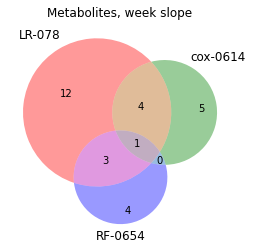

set()


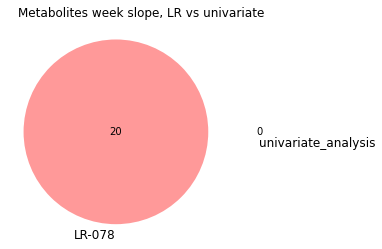

set()


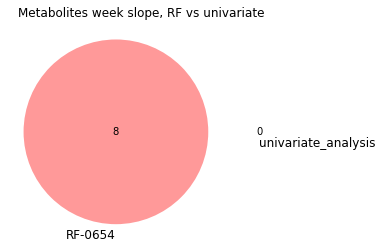

set()


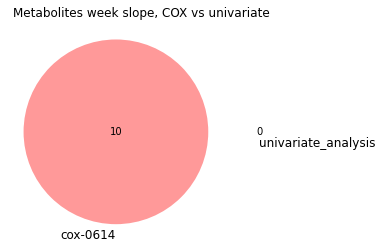

ttest_metabs2.csv
set()

RF-0842 vs LR-0741
{'1-palmitoyl-2-stearoyl-GPC (16:0/18:0)'}

cox-081 vs LR-0741
{'behenoyl ethanolamide (22:0)*', 'octadecenedioate (C18:1-DC)'}

RF-0842 vs cox-081
{'thymidine'}



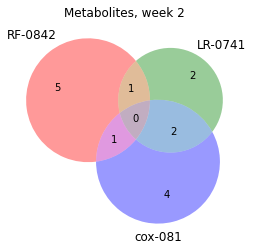

{'behenoyl ethanolamide (22:0)*', 'sphingomyelin (d18:2/24:1, d18:1/24:2)*', 'octadecenedioate (C18:1-DC)', '1-palmitoyl-2-stearoyl-GPC (16:0/18:0)'}


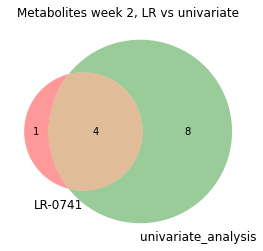

{'1-palmitoyl-2-stearoyl-GPC (16:0/18:0)', 'taurochenodeoxycholic acid 3-sulfate', 'thymidine', 'lignoceroyl sphingomyelin (d18:1/24:0)'}


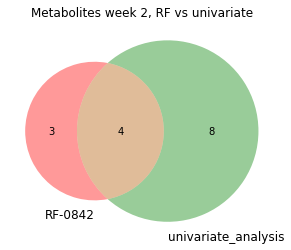

{'behenoyl ethanolamide (22:0)*', 'thymidine', 'octadecenedioate (C18:1-DC)'}


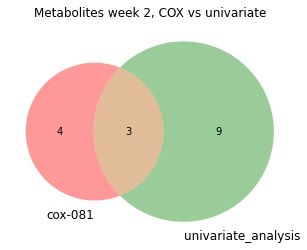

ttest_metabs1.csv
{'N-carbamoylaspartate', 'vanillylmandelate (VMA)'}

RF-0639 vs cox-0604
{'1-palmitoyl-2-linoleoyl-digalactosylglycerol (16:0/18:2)*', 'N-carbamoylaspartate', 'bilirubin (E,E)*', 'vanillylmandelate (VMA)'}

LR-0751 vs cox-0604
{'N-carbamoylaspartate', 'vanillylmandelate (VMA)'}

RF-0639 vs LR-0751
{'N-carbamoylaspartate', 'vanillylmandelate (VMA)'}



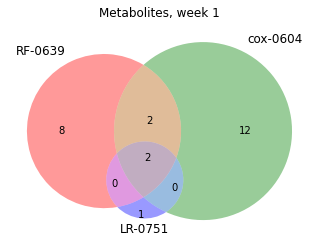

{'vanillylmandelate (VMA)', 'N-carbamoylaspartate'}


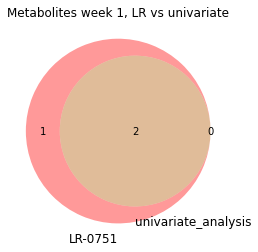

{'vanillylmandelate (VMA)', 'N-carbamoylaspartate'}


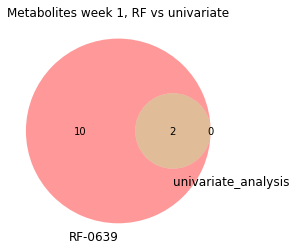

{'vanillylmandelate (VMA)', 'N-carbamoylaspartate'}


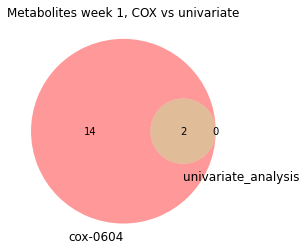

In [66]:
path = 'univariate_analysis/metabs/'
met_dict = {}

for file in os.listdir(path):
    if '.csv' not in file:
        continue
    if 'ranksum' in file or 'rank_sum' in file:
        continue
    if '1.5' in file and '[' not in file:
        continue
    
    metabs = pd.read_csv(path + file, index_col = 0)
    nm = str(file.split('.')[0].split('s')[-1])
    if len(nm)>1:
        nm = 'slope'
    if nm not in ['1','2','slope']:
        continue
        
    print(file)
    met_dict[nm] = {}
    names_tot = []
    
    feat_folder = 'feature_tables/' + 'metabs_' + nm
    fnames = []
    for feat_file in os.listdir(feat_folder):
        met_dict[nm][feat_file.split('.')[0]] = {}
        feats = pd.read_csv(feat_folder + '/' + feat_file, index_col = 0)
        names = []
        for f in feats.index.values:
            try:
                interval = [float(feats['95%'].loc[f].split('(')[1].split(',')[0]), 
                            float(feats['95%'].loc[f].split(')')[0].split(', ')[1])]
            except:
                interval = [float(feats['95% Interval'].loc[f].split('(')[1].split(',')[0]), 
                            float(feats['95% Interval'].loc[f].split(')')[0].split(', ')[1])]
            if max(interval)<1. or min(interval)>1.:
                names.append(f)
        met_dict[nm][feat_file.split('.')[0]]['names'] = names
        pubchem_nums = dl.col_mat_mets['PUBCHEM'].loc[names]
        kegg_nums = dl.col_mat_mets['KEGG'].loc[names]
        hmbd_nums = dl.col_mat_mets['HMDB'].loc[names]
        met_dict[nm][feat_file.split('.')[0]]['pubchem'] = pubchem_nums
        met_dict[nm][feat_file.split('.')[0]]['kegg_nums'] = kegg_nums
        met_dict[nm][feat_file.split('.')[0]]['hmbd_nums'] = hmbd_nums
        if '16s' not in feat_file.split('.')[0] and feat_file.split('.')[0] != '':
            fnames.append(feat_file.split('.')[0])
            names_tot.extend(names)
        
                
    names = list(metabs.index.values[metabs['BH corrected']<0.1])
    met_dict[nm]['univariate_analysis'] = {}
    met_dict[nm]['univariate_analysis']['names'] = names
    pubchem_nums = dl.col_mat_mets['PUBCHEM'].loc[names]
    kegg_nums = dl.col_mat_mets['KEGG'].loc[names]
    hmbd_nums = dl.col_mat_mets['HMDB'].loc[names]
    met_dict[nm]['univariate_analysis']['pubchem'] = pubchem_nums
    met_dict[nm]['univariate_analysis']['kegg_nums'] = kegg_nums
    met_dict[nm]['univariate_analysis']['hmbd_nums'] = hmbd_nums
#     pd.DataFrame(met_dict[nm]).T.to_csv('enrichment_sets/feats_' + nm + '.csv')
    names_tot.extend(names)
    
    names_df = dl.col_mat_mets[['PUBCHEM','HMDB','KEGG']].loc[np.unique(names_tot)]
#     names_df.to_csv('enrichment_sets/feat_sets_' + nm + '.csv')
    
    
    plt.figure()
    venn3([set(met_dict[nm][fnames[0]]['names']), set(met_dict[nm][fnames[1]]['names']), 
           set(met_dict[nm][fnames[2]]['names'])], 
         set_labels = (fnames[0], fnames[1], fnames[2]))
    print(set(set(met_dict[nm][fnames[0]]['names']).intersection(set(
        met_dict[nm][fnames[1]]['names']))).intersection(set(met_dict[nm][fnames[2]]['names'])))
    print('')
    print(fnames[0] +' vs '+fnames[1])
    print(set(met_dict[nm][fnames[0]]['names']).intersection(set(
        met_dict[nm][fnames[1]]['names'])))
    print('')
    print(fnames[2] +' vs '+fnames[1])
    print(set(met_dict[nm][fnames[2]]['names']).intersection(set(
        met_dict[nm][fnames[1]]['names'])))
    print('')
    print(fnames[0] +' vs '+fnames[2])
    print(set(met_dict[nm][fnames[0]]['names']).intersection(set(
        met_dict[nm][fnames[2]]['names'])))
    print('') 
    plt.title('Metabolites, week ' + nm)
    plt.show()
    
    plt.figure()
    fnames = [m for m in list(met_dict[nm].keys()) if 'LR' in m]
    venn2([set(met_dict[nm][fnames[0]]['names']), set(met_dict[nm]['univariate_analysis']['names'])], 
         set_labels = (fnames[0], 'univariate_analysis'))
    plt.title('Metabolites week ' + nm + ', LR vs univariate')
    print(set(met_dict[nm][fnames[0]]['names']).intersection(set(met_dict[nm]['univariate_analysis']['names'])))
    plt.show()
    
    plt.figure()
    fnames = [m for m in list(met_dict[nm].keys()) if 'RF' in m]
    venn2([set(met_dict[nm][fnames[0]]['names']), set(met_dict[nm]['univariate_analysis']['names'])], 
         set_labels = (fnames[0], 'univariate_analysis'))
    print(set(met_dict[nm][fnames[0]]['names']).intersection(set(met_dict[nm]['univariate_analysis']['names'])))
    plt.title('Metabolites week ' + nm + ', RF vs univariate')
    plt.show()
    
    plt.figure()
    fnames = [m for m in list(met_dict[nm].keys()) if 'cox' in m]
    venn2([set(met_dict[nm][fnames[0]]['names']), set(met_dict[nm]['univariate_analysis']['names'])], 
         set_labels = (fnames[0], 'univariate_analysis'))
    print(set(met_dict[nm][fnames[0]]['names']).intersection(set(met_dict[nm]['univariate_analysis']['names'])))
    plt.title('Metabolites week ' + nm + ', COX vs univariate')
    plt.show()
    
#     if nm == 'slope':
#         plt.figure()
#         fnames = [m for m in list(met_dict[nm].keys()) if 'RF' in m]
#         venn2([set(met_dict[nm][fnames[0]]['names']), set(met_dict[nm][fnames[1]]['names'])], 
#               set_labels = (fnames[0], fnames[1]))
#         plt.title('Metabs-16s vs Metabs for RF slope')

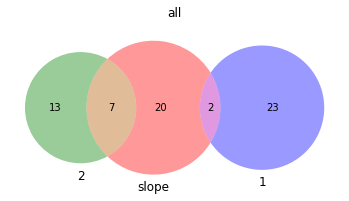

In [69]:
all_vals = [set(np.concatenate([met_dict[i][k]['names'] for k in met_dict[i].keys()])) for i in met_dict.keys()]
plt.figure()
plt.title('all')
venn3(all_vals, set_labels = met_dict.keys())
plt.show()

{'solanidine', 'sphingomyelin (d18:2/24:1, d18:1/24:2)*', '1-palmitoyl-2-stearoyl-GPC (16:0/18:0)'}


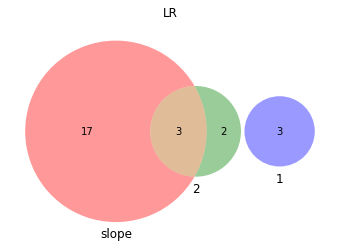

{'2-acetamidobutanoate', '1-methylhypoxanthine', 'N-acetyl-3-methylhistidine*'}


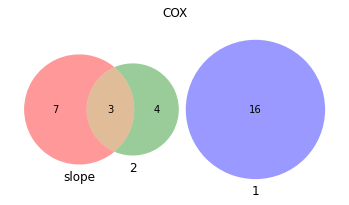

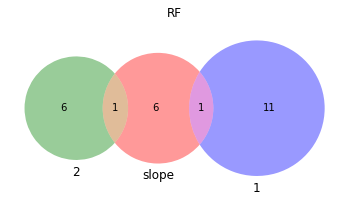

In [75]:
lr_vals = [set([met_dict[i][k]['names'] for k in met_dict[i].keys() 
                           if 'LR' in k][0]) for i in met_dict.keys()]

plt.figure()
plt.title('LR')
print(lr_vals[0].intersection(lr_vals[1]))
venn3(lr_vals, set_labels = met_dict.keys())
plt.show()

cox_vals = [set([met_dict[i][k]['names'] for k in met_dict[i].keys() 
                           if 'cox' in k][0]) for i in met_dict.keys()]
plt.figure()
plt.title('COX')
print(cox_vals[0].intersection(cox_vals[1]))

venn3(cox_vals, set_labels = met_dict.keys())
plt.show()
rf_vals = [set([met_dict[i][k]['names'] for k in met_dict[i].keys() 
                           if 'RF' in k][0]) for i in met_dict.keys()]
plt.figure()
plt.title('RF')
venn3(rf_vals, set_labels = met_dict.keys())
plt.show()

In [ ]:
by_hand_dict = {'1-palmitoyl-2-stearoyl-GPC (16:0/18:0)':
                {'HMDB':'HMDB07970'}, {'PUBCHEM': 24778686},
               'taurohyocholate': {'PUBCHEM': 11954195},
               'sphingomyelin (d18:2/24:1, d18:1/24:2)*': 44260126,
               'octadecenedioate (C18:1-DC)': 9543674}

In [37]:
for k,v in met_dict.items():
    print(k)
    print(pd.DataFrame(met_dict[k]))
    print('')

slope
Empty DataFrame
Columns: [names, pubchem, kegg_nums, hmbd_nums]
Index: []

1
                     names  pubchem kegg_nums  hmbd_nums
0  vanillylmandelate (VMA)     1245    C05584  HMDB00291
1     N-carbamoylaspartate    93072    C00438  HMDB00828

2
                                      names    pubchem kegg_nums  hmbd_nums
0             behenoyl ethanolamide (22:0)*  3023585.0       NaN        NaN
1    1-palmitoyl-2-stearoyl-GPC (16:0/18:0)        NaN       NaN  HMDB07970
2    lignoceroyl sphingomyelin (d18:1/24:0)        NaN       NaN        NaN
3                          taurohyocholate*        NaN       NaN        NaN
4   sphingomyelin (d18:2/24:1, d18:1/24:2)*        NaN       NaN        NaN
5                                D-urobilin  6276321.0    C05795  HMDB04161
6               octadecenedioate (C18:1-DC)        NaN       NaN        NaN
7   sphingomyelin (d18:1/20:0, d16:1/22:0)*        NaN       NaN  HMDB12102
8                                 thymidine     5789.0    C